In [49]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import pickle 

import helper_functions
reload(helper_functions)
from helper_functions import accuracy_rate, load_data, capacity, get_good_idx, get_slice, get_k_fold_cv_idx, get_x_sequences_rnn, train, get_all_accuracy_rates, allocate_x_batch_rnn, quantile_score, get_competition_preds

nn_type = 'rnn'
allocate_x_batch = allocate_x_batch_rnn
get_x_sequences = get_x_sequences_rnn


In [59]:
np.random.seed(2021)

case=1
x,x_time,y,y_time,time_dif,idx_offset = load_data(case)

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
pred_seq_len = 50


#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-pred_seq_len+1:i+idx_offset+1])

good_idx = get_good_idx(x,y,idx_offset,pred_seq_len)


print(x.shape)
print(y.shape)
print(x_time[0])
print(y_time[0])
print(len(good_idx))

torch.Size([182918, 16])
torch.Size([147205, 1])
2016-01-01 20:00:00
2017-01-07 20:15:00
135894


In [51]:
input_size = x.shape[1]
num_channels = input_size
hidden_size = 70
num_hidden = 5
out_size = 1
drop_p=0.005
rnn_type='gru'

# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  
        
        
        if rnn_type.lower()=='lstm':
            self.rnn_layers = nn.LSTM(input_size=num_channels,
                                  hidden_size=hidden_size,
                                  num_layers=num_hidden+1,
                                  batch_first=True, # batch_size x sequence_length x input_size
                                  bias=True,
                                  dropout=drop_p)
        elif rnn_type.lower()=='gru':
            self.rnn_layers = nn.GRU(input_size=num_channels,
                                 hidden_size=hidden_size,
                                 num_layers=num_hidden+1,
                                 batch_first=True, # batch_size x sequence_length x input_size
                                 bias=True,
                                 dropout=drop_p)
        else:
            raise(Exception('unknown rnn type'))
            
        self.l_out = nn.Linear(in_features=pred_seq_len * hidden_size,
                               out_features=out_size,
                               bias=True)
        
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_p)
        
        
    def forward(self, x):
        #x, (h, c) = self.lstm(x)
        x = self.rnn_layers(x)[0]
        x = x.reshape(-1, pred_seq_len * hidden_size)
        x = self.dropout(x)
        x = self.act(x)  
        x = self.l_out(x)
        return x


net = Net()
print(net)

optimizer = optim.Adam(net.parameters())
loss = nn.MSELoss()

Net(
  (rnn_layers): GRU(16, 70, num_layers=6, batch_first=True, dropout=0.005)
  (l_out): Linear(in_features=3500, out_features=1, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.005)
)


In [4]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1000
num_epochs = 80
k_fold_size = 1

loss = nn.MSELoss()
#loss = nn.L1Loss()


optim_params = {'lr': 3e-3, 'weight_decay': 0}
train_loss, valid_loss, net = train(nn_type, x, y, Net, optim_params, num_epochs, batch_size, good_idx, k_fold_size, idx_offset, pred_seq_len, loss, case)
valid_loss[0] = np.sqrt(valid_loss[0])

#np.savez(outfile, train_loss=train_loss, valid_loss=valid_loss)

KeyboardInterrupt: 

In [16]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss[0, :], 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('MSE [normalized units]')
plt.show()

plt.figure()
plt.plot(epoch, capacity(case)*np.array(valid_loss[:-1]).T)
plt.legend(['rmse','mae','quantile score'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()

plt.figure()
plt.plot(epoch, valid_loss[-1])
plt.xlabel('Updates'), plt.ylabel('Accuracy rate')
plt.show()


NameError: name 'valid_loss' is not defined

<Figure size 432x288 with 0 Axes>

In [60]:
with open(f'final_net/rnn_--num_hidden_5_--hidden_size_70_--pred_seq_len_50_--loss_mse_--weight_decay_0_--dropout_0.005_--rnn_type_gru_--case_{case}.pkl', 'rb') as inp:
    net = pickle.load(inp)

In [61]:
split=10
predictions=np.zeros((0,1))
print(predictions.shape)
for i in range(split):
    idx = good_idx[i*len(good_idx)//split:(i+1)*len(good_idx)//split]
    
    x_batch = allocate_x_batch(len(idx), input_size, pred_seq_len)
    predictions = np.vstack((predictions,net(get_x_sequences(idx, x_batch, idx_offset, pred_seq_len, x)).detach().numpy()))
    print(predictions.shape)
    

(0, 1)
(13589, 1)
(27178, 1)
(40768, 1)
(54357, 1)
(67947, 1)
(81536, 1)
(95125, 1)
(108715, 1)
(122304, 1)
(135894, 1)


In [63]:
assert len(good_idx)==predictions.shape[0]    

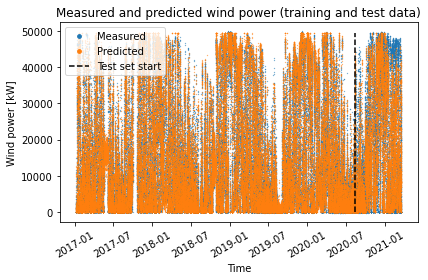

In [64]:
predictions = np.clip(predictions, 0, 1)
plt.plot(y_time[good_idx], capacity(case)*y[good_idx].detach().numpy(), '.', markersize=0.5, label = 'Measured')
plt.plot(y_time[good_idx], capacity(case)*predictions,'.', markersize=0.5, label = 'Predicted')
plt.plot((y_time[good_idx[-20000]],y_time[good_idx[-20000]]), (0, capacity(case)),'--',color='black',label='Test set start')
lgnd = plt.legend(markerscale=15, loc='upper left')    
plt.xticks(rotation=30)
plt.ylabel('Wind power [kW]')
plt.xlabel('Time')
plt.title('Measured and predicted wind power (training and test data)')
plt.tight_layout()
plt.savefig(f'plots/predictions_{nn_type}_case_{case}.png')
plt.show()

In [65]:
print(accuracy_rate(torch.Tensor(predictions[-20000:]*capacity(case)), y[good_idx[-20000:]]*capacity(case), capacity(case)))



tensor(0.7631)


In [31]:
x_batch = allocate_x_batch(96, input_size, pred_seq_len)
accuracies, times = get_all_accuracy_rates(net, x, y, y_time, x_batch, get_x_sequences, good_idx, idx_offset, pred_seq_len, case)


KeyboardInterrupt: 

In [ ]:
plt.plot(times, accuracies)
plt.xticks(rotation=30)
plt.ylim(0.3,1)
plt.show()
print('Mean accuracy rate', np.mean(accuracies))

In [ ]:
day=0
save=False
predictions = get_competition_preds(day,case,get_x_sequences,allocate_x_batch,input_size,pred_seq_len,net,save)

In [18]:
print(len(good_idx))

109345
